In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

import os, sys
import time
import pandas as pd
import matplotlib.pyplot as plt
# Add the parent directory (one level up) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import pipeline

In [7]:
from modules.adaptive.filters.collaborative import CollaborativeFiltering
from modules.personalization.recommender import Recommender
from surprise import SVD

In [8]:
svd_params = {
    'n_factors': 200,
    'n_epochs': 100,
    'lr_all': 0.01,
    'reg_all': 0.1
}
model = CollaborativeFiltering(
    algorithm=SVD(**svd_params),
    ratings_file='../storage/u.data',
    metadata_file='../storage/u.item'
)
model.fit()

recommender = Recommender(model=model)
rankings = recommender.rank_items(user_id=196, top_n=10)
print(rankings)

   item     score
0  1512  4.666960
1   663  4.543419
2  1449  4.532096
3   483  4.507642
4  1639  4.495263
5   318  4.492092
6   285  4.491241
7   197  4.488740
8    64  4.479587
9   119  4.478748


In [26]:
import requests
import time

response_times = []

for i in range(0, 900):

    # Define the URL and parameters
    url = "http://localhost:5000/recommend?user_id={i}"
    # params = {"user_id": 780}  # Query parameters

    # Measure time taken for the request
    start_time = time.time()
    response = requests.get(url)
    end_time = time.time()

    elapsed_time = end_time - start_time

    response_times.append(elapsed_time)

Text(0.5, 1.0, 'Docker Recommendation Response Time Distribution')

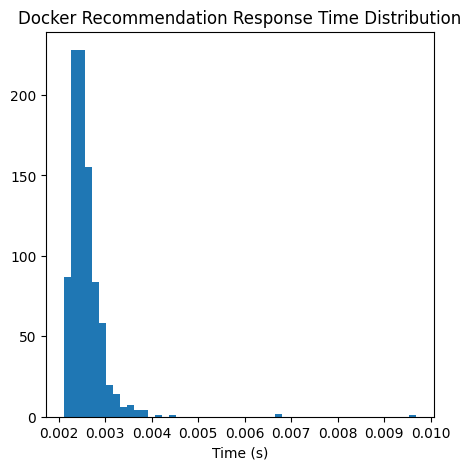

In [31]:

plt.figure(figsize = (5, 5))
plt.hist(response_times, bins = 50)
plt.xlabel('Time (s)')
plt.title('Docker Recommendation Response Time Distribution')